# Square lattice

In [72]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import math
from math import sqrt, pi
from numpy import cos, exp, sin
import pybinding as pb
from pybinding.repository import graphene
pb.pltutils.use_style()


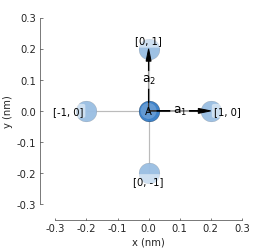

In [73]:


d = 0.2  # [nm] unit cell length
t = 1    # [eV] hopping energy

# create a simple 2D lattice with vectors a1 and a2
lattice = pb.Lattice(a1=[d, 0], a2=[0, d])
lattice.add_sublattices(
    ('A', [0, 0])  # add an atom called 'A' at position [0, 0]
)
lattice.add_hoppings(
    # (relative_index, from_sublattice, to_sublattice, energy)
    ([0, -1], 'A', 'A', t),
    ([-1, 0], 'A', 'A', t)
)
lattice.plot()  # plot the lattice that was just constructed
plt.show()      # standard matplotlib show() function


# Graphene monolayer

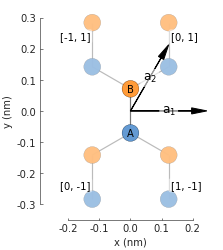

In [74]:
import pybinding as pb
import matplotlib.pyplot as plt
from math import sqrt

def monolayer_graphene():
    a = 0.24595   # [nm] unit cell length
    a_cc = 0.142  # [nm] carbon-carbon distance
    t = -2.8      # [eV] nearest neighbour hopping

    lat = pb.Lattice(a1=[a, 0],
                     a2=[a/2, a/2 * sqrt(3)])
    lat.add_sublattices(('A', [0, -a_cc/2]),
                        ('B', [0,  a_cc/2]))
    lat.add_hoppings(
        # inside the main cell
        ([0,  0], 'A', 'B', t),
        # between neighboring cells
        ([1, -1], 'A', 'B', t),
        ([0, -1], 'A', 'B', t)
    )
    return lat


lattice = monolayer_graphene()
lattice.plot()
plt.show()


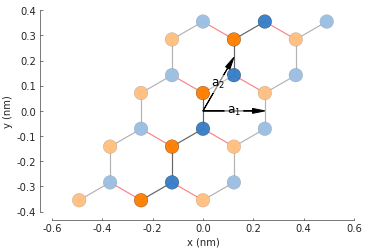

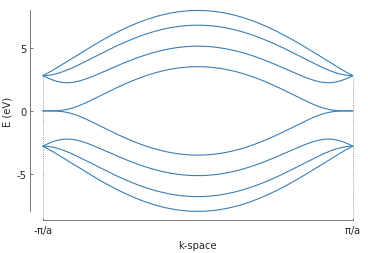

In [75]:
a_cc = graphene.a_cc
a = np.sqrt(3)*a_cc

h =4*a
w =4*a

model = pb.Model(
        monolayer_graphene(),
        pb.rectangle(h,w),
        pb.translational_symmetry(a1=True,a2 =False)
)

model.plot()
model.lattice.plot_vectors(position=[0,0])
plt.show()


Gamma = [0, 0]
K1 = [-4*pi / (3*sqrt(3)*a_cc), 0]

solver = pb.solver.lapack(model)
#bands = solver.calc_bands(K1, Gamma)
#bands.plot(point_labels=['K1', r'$\Gamma$'])
bands = solver.calc_bands(-pi/a,pi/a)
bands.plot(point_labels=[r'-$\pi/a$', r'$\pi/a$'])



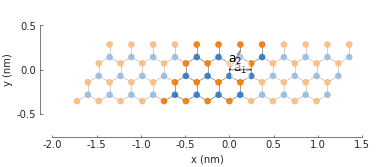

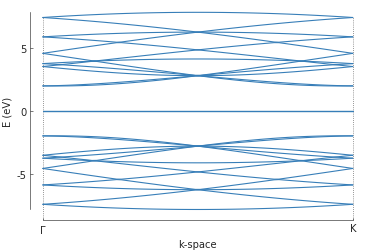

In [77]:
a_cc = graphene.a_cc
a = np.sqrt(3)*a_cc

h =4*a
w =4*a
w4 = 24*(a)

model = pb.Model(
        monolayer_graphene(),
        pb.translational_symmetry(a1=h,a2 =w),#(a1=True,a2 =True),
        pb.rectangle(2*h,w),
)
#rint(w)
model.plot()
model.lattice.plot_vectors(position=[0,0])
plt.show()


Gamma = [-pi/w, 0]
K1 = [pi/w, 0]

solver = pb.solver.lapack(model)
bands = solver.calc_bands(K1, Gamma)
bands.plot(point_labels=['K', r'$\Gamma$'])
#plt.ylim(-1,1)
plt.show()

#bands = solver.calc_bands(-pi/a,pi/a)
#bands.plot(point_labels=[r'-$\pi/a$', r'$\pi/a$'])



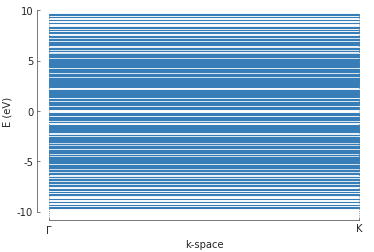

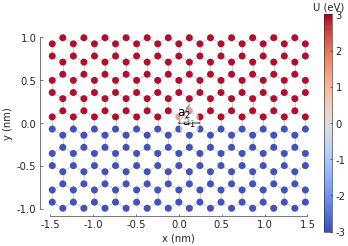

In [88]:
def pn_junction(y0, v1, v2):
    @pb.onsite_energy_modifier
    def potential(energy, y):
        energy[y < y0] += v1
        energy[y >= y0] += v2
        return energy
    
    return potential
Gamma = [ 0, -pi/w]
K1 = [0,pi/w]

solver = pb.solver.lapack(model)
bands = solver.calc_bands(K1, Gamma)
bands.plot(point_labels=['K', r'$\Gamma$'])
plt.show()

model = pb.Model(
    monolayer_graphene(),
    pb.rectangle(3,2),
    #pb.translational_symmetry(a1=True, a2=False),
    pn_junction(y0=0, v1=-3, v2=3)
)

model.onsite_map.plot(cmap="coolwarm", site_radius=0.04)
pb.pltutils.colorbar(label="U (eV)")
#model.plot()
model.lattice.plot_vectors(position=[0,0])
plt.show()


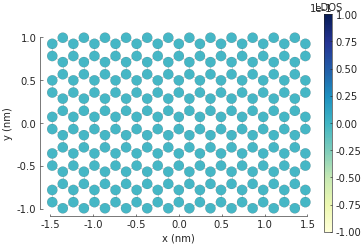

In [27]:
pb.pltutils.use_style()
%matplotlib inline

solver = pb.solver.arpack(model, k=20)
ldos=solver.calc_spatial_ldos(energy=0,broadening=0.001)#ev

ldos.plot(site_radius = (0.0,0.06))
pb.pltutils.colorbar(label='LDOS')
plt.show()

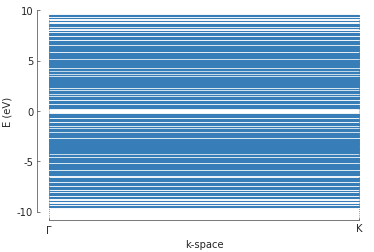

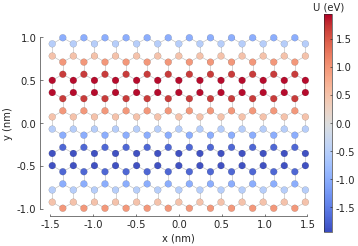

In [90]:
import numpy as np


def sine_potential(V1,w1):
#potential equals to siny
    @pb.onsite_energy_modifier

    def potential(energy, sub_id,x,y):
        energy += V1*np.sin(2*np.pi*y/(3*(w1)*a_cc))
        return energy
    
    return potential

#a_cc = graphene.a_cc
#a = np.sqrt(3)*a_cc
a_cc = 0.142 #nm
V1 = 2
w1 = 4
w=2
Gamma = [ 0, -pi/w]
K1 = [0,pi/w]

solver = pb.solver.lapack(model)
bands = solver.calc_bands(K1, Gamma)
bands.plot(point_labels=['K', r'$\Gamma$'])
#plt.ylim(-1,1)
plt.show()

model = pb.Model(
    monolayer_graphene(),
    pb.rectangle(3,2),
    #pb.translational_symmetry(a1=True, a2=2),
    sine_potential(V1,w1)
)
model.onsite_map.plot(cmap="coolwarm", site_radius=0.04)
pb.pltutils.colorbar(label="U (eV)")



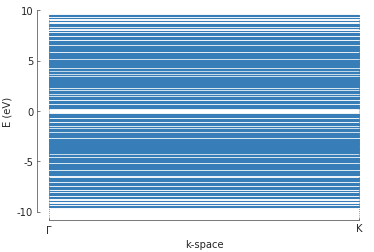

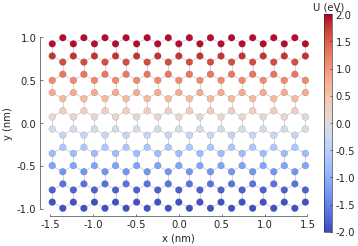

In [134]:
import numpy as np

def mass_termy_kink(V1,w1,w2,w3):
#This function makes potential difference along y axes. And it changes gradually
    @pb.onsite_energy_modifier
    def potential(energy, sub_id,x,y):
        yrange=w3*3*(w1+w2)*a_cc/2
        energy[y>=yrange] += V1
        energy[(y<yrange)&(y>=-yrange)] += V1/(yrange)*y[(y<yrange)&(y>=-yrange)]
        energy[y<-yrange] -= V1
        return energy

    return potential

#a_cc = 0.142 #nm
#V1 = 2
#w1 = 3
#w2 = 1
#w3 = 1

Gamma = [ 0, -pi/w]
K1 = [0,pi/w]

solver = pb.solver.lapack(model)
bands = solver.calc_bands(K1, Gamma)
bands.plot(point_labels=['K', r'$\Gamma$'])
plt.show()

a_cc = 0.142 #nm
V1 = 2
w1 = 3
w2 = 1
w3 = 1

model = pb.Model(
    monolayer_graphene(),
    pb.rectangle(3,2),
    #pb.translational_symmetry(a1=True, a2=False),
    mass_termy_kink(V1,w1,w2,w3)
)
model.onsite_map.plot(cmap="coolwarm", site_radius=0.04)
pb.pltutils.colorbar(label="U (eV)")


# Zig-zag nano ribbon

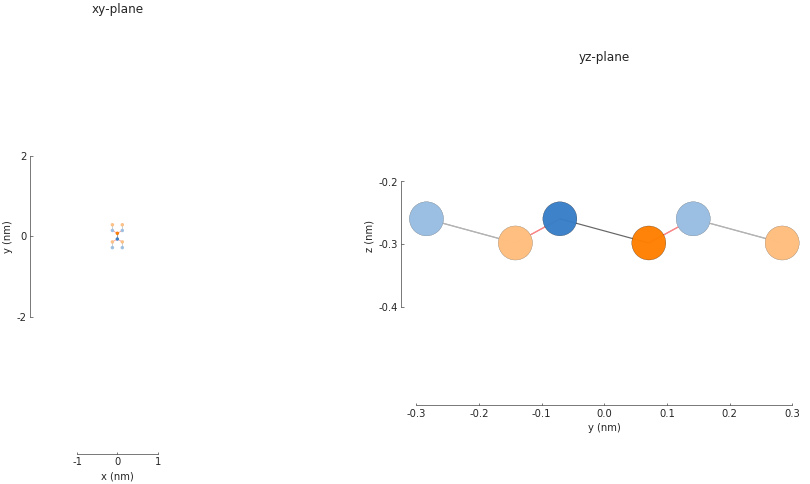

In [138]:
w1,w2 =10/a_cc/3,10/a_cc/3 
height=3.2

def strain(height,w1,w2):
    """Out-of-plane deformation (bump)"""
    @pb.site_position_modifier
    def displacement(x, y, z):
        sigma=1.6*(w1+w2)/10*a_cc*3 #I set this value to automatically matches to w1,w2
        dz = height * np.exp(-((y-(w1+w2)/4*3*a_cc)**2) / sigma**2)  # gaussian
        return x, y, z - dz  # only the height changes

    @pb.hopping_energy_modifier
    def strained_hoppings(energy, x1, y1, z1, x2, y2, z2):
        d = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)  # strained neighbor distance
        return energy * np.exp(-3.37 * (d / graphene.a_cc - 1))  # see strain section

    return displacement, strained_hoppings

model = pb.Model(
    monolayer_graphene(),
    pb.rectangle(20,20),
    pb.translational_symmetry(a1=True, a2=True),
    pn_junction(y0=0, v1=-20, v2=20),
    strain(height=height, w1=w1,w2=w2)
)



plt.figure(figsize=(16, 8))
plt.subplot(121, title="xy-plane", ylim=[-5, 5])
model.plot()
plt.subplot(122, title="yz-plane")
model.plot(axes="yz")

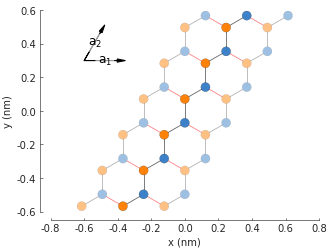

In [16]:
model = pb.Model(
    monolayer_graphene(),
    pb.rectangle(1.2),  # nm
    pb.translational_symmetry(a1=True, a2=False)
)

model.plot()
model.lattice.plot_vectors(position=[-0.6,0.3])
plt.show() 

# Band structures

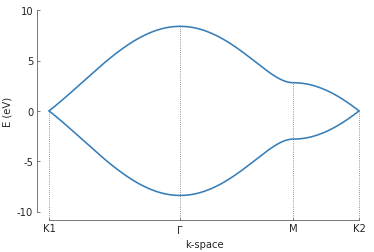

In [17]:
from math import sqrt, pi

model = pb.Model(monolayer_graphene(), pb.translational_symmetry())
solver = pb.solver.lapack(model)

a_cc = graphene.a_cc
Gamma = [0, 0]
K1 = [-4*pi / (3*sqrt(3)*a_cc), 0]
M = [0, 2*pi / (3*a_cc)]
K2 = [2*pi / (3*sqrt(3)*a_cc), 2*pi / (3*a_cc)]

solver = pb.solver.lapack(model)
bands = solver.calc_bands(K1, Gamma, M, K2)
bands.plot(point_labels=['K1', r'$\Gamma$', 'M', 'K2'])



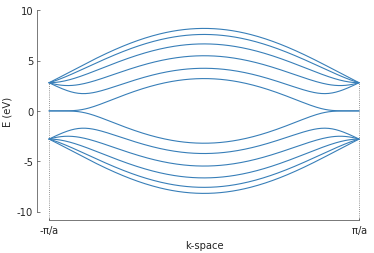

In [18]:
model = pb.Model(
    monolayer_graphene(),
    pb.rectangle(1.2),  # nm
    pb.translational_symmetry(a1=True, a2=False)
)


solver = pb.solver.lapack(model)
a = graphene.a_cc * sqrt(3)  # ribbon unit cell length
bands = solver.calc_bands(-pi/a, pi/a)
bands.plot(point_labels=[r'-$\pi$/a', r'$\pi$/a'])

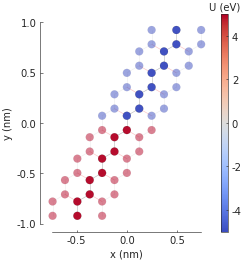

In [19]:
def pn_junction(y0, v1, v2):
    @pb.onsite_energy_modifier
    def potential(energy, y):
        energy[y < y0] += v1
        energy[y >= y0] += v2
        return energy
    return potential

model = pb.Model(
    monolayer_graphene(),
    pb.rectangle(1.2,20),
    pb.translational_symmetry(a1=True, a2=False),
    pn_junction(y0=0, v1=5, v2=-5)
)
model.onsite_map.plot(cmap="coolwarm", site_radius=0.04)
pb.pltutils.colorbar(label="U (eV)")

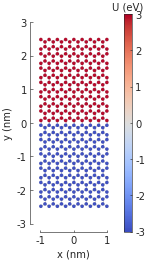

In [20]:
def pn_junction(y0, v1, v2):
    @pb.onsite_energy_modifier
    def potential(energy, y):
        energy[y < y0] += v1
        energy[y >= y0] += v2
        return energy
    return potential

model = pb.Model(
    monolayer_graphene(),
    pb.rectangle(2,5),
    #pb.translational_symmetry(a1=True, a2=False),
    pn_junction(y0=0, v1=-3, v2=3)
)
model.onsite_map.plot(cmap="coolwarm", site_radius=0.04)
pb.pltutils.colorbar(label="U (eV)")

# Practice to make lattice structures

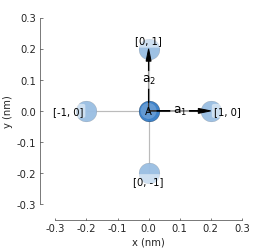

In [40]:
import pybinding as pb

d = 0.2  # [nm] unit cell length
t = 1    # [eV] hopping energy

# create a simple 2D lattice with vectors a1 and a2
lattice = pb.Lattice(a1=[d, 0], a2=[0, d])
lattice.add_sublattices(
    ('A', [0, 0])  # add an atom called 'A' at position [0, 0]
)
lattice.add_hoppings(
    # (relative_index, from_sublattice, to_sublattice, energy)
    ([0, 1], 'A', 'A', t),
    ([1, 0], 'A', 'A', t)
)
lattice.plot()
plt.show()

In [ ]:
import pybinding as pb

d = 0.2  # [nm] unit cell length
t = 1    # [eV] hopping energy

# create a simple 2D lattice with vectors a1 and a2
lattice = pb.Lattice(a1=[d, 0], a2=[0, d])
lattice.add_sublattices(
    ('A', [0, 0])  # add an atom called 'A' at position [0, 0]
)
lattice.add_hoppings(
    # (relative_index, from_sublattice, to_sublattice, energy)
    ([0, 1], 'A', 'A', t),
    ([1, 0], 'A', 'A', t)
)
lattice.plot()
plt.show()